In [27]:
import numpy as np
import random
import sys, os
import torch as t

def set_all_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    t.manual_seed(seed)
    t.cuda.manual_seed(seed)
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = True
    
set_all_seeds(0)

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
import feature_corrs
import pandas as pd

In [30]:
from datasets import load_dataset, Dataset

In [31]:
from sae_lens import (
    SAE,
    ActivationsStore,
    HookedSAETransformer,
    LanguageModelSAERunnerConfig,
    SAEConfig,
    SAETrainingRunner,
    upload_saes_to_huggingface,
)

In [32]:
import pandas as pd

## display configuration

In [42]:
from IPython.display import HTML, IFrame, clear_output, display
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory

In [45]:
def display_dashboard(
    sae_release="gpt2-small-res-jb",
    layer=7,
    latent_idx=0,
    width=800,
    height=600,
    lt = 'pre'
):
    sae_id = f"blocks.{layer}.hook_resid_{lt}"
    release = get_pretrained_saes_directory()[sae_release]
    print(release)
    neuronpedia_id = release.neuronpedia_id[sae_id]
    print(neuronpedia_id)

    url = f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

    print(url)
    display(IFrame(url, width=width, height=height))


latent_idx = 228
#display_dashboard(layer=7, latent_idx=latent_idx)

## loading dataset

In [98]:
imdb_dataset = load_dataset("stanfordnlp/imdb", split="train")
subset_size = 50000
batch_size = 8
max_length = 20
imdb_subset = imdb_dataset.shuffle(seed=0).select(range(subset_size))

IndexError: Index 49999 out of range for dataset of size 25000.

In [1]:
imdb_dataset.shuffle()[0]

NameError: name 'imdb_dataset' is not defined

In [133]:
imdb_dataset.shuffle().select(range(subset_size)).select(range(subset_size))['text'][0]

"The first time I saw this film, I loved it. It was different.<br /><br />I am a Christian (Bible believing). I don't go along with the crowd of right wing believers. I dropped out of that atmosphere.<br /><br />To me in their attempts to take over our government they are doing what Judas tried to do. I call it the Judas Syndrome.<br /><br />Judas didn't get it, even though Jesus said his Kingdom was not of this world.<br /><br />This film certainly showed some of that.<br /><br />I also liked that Jesus enjoyed the simple pleasure of playing games and jokes with his disciples.<br /><br />Also he was a very gorgeous Jesus.<br /><br />It's a watch-over and over movie.<br /><br />Very satisfying."

In [127]:
imdb_subset['text'][12]

'Never cast models and Playboy bunnies in your films! Bob Fosse\'s "Star 80" about Dorothy Stratten, of whom Bogdanovich was obsessed enough to have married her SISTER after her murder at the hands of her low-life husband, is a zillion times more interesting than Dorothy herself on the silver screen. Patty Hansen is no actress either..I expected to see some sort of lost masterpiece a la Orson Welles but instead got Audrey Hepburn cavorting in jeans and a god-awful "poodlesque" hair-do....Very disappointing...."Paper Moon" and "The Last Picture Show" I could watch again and again. This clunker I could barely sit through once. This movie was reputedly not released because of the brouhaha surrounding Ms. Stratten\'s tawdry death; I think the real reason was because it was so bad!'

## importing and inspecting

In [36]:
diffs7 = np.load("diffs_blocks.7.hook_resid_pre.npy")

In [23]:
import matplotlib.pyplot as plt

/home/users/sv226/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


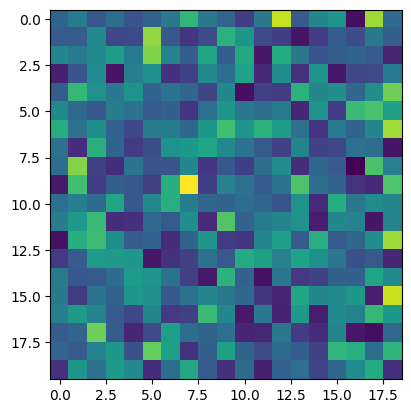

In [28]:
plt.imshow(diffs7[:20,1:])

In [34]:
diffs8 = np.load("diffs_blocks.8.hook_resid_pre.npy")

In [41]:
diffs7[2]

array([1108.5535  ,   34.405243,   20.875195,   56.34616 ,   44.779182,
         27.647322,   33.601475,   43.624973,   40.8872  ,   29.786343,
         39.27654 ,   49.949825,   32.98101 ,   27.915873,   45.136875,
         32.50765 ,   35.582756,   20.40806 ,   37.275017,   28.007952],
      dtype=float32)

In [42]:
diffs8[2]

array([1106.587   ,   39.16715 ,   36.737274,   39.831062,   44.305702,
         36.23438 ,   58.193222,   38.234432,   29.73148 ,   45.70475 ,
         30.433235,   47.00953 ,   17.410069,   47.778362,   35.58739 ,
         28.32014 ,   30.527891,   31.455044,   29.543417,   19.660187],
      dtype=float32)

In [163]:
codes7 = np.load("codes_blocks.7.hook_resid_pre.npy")

In [164]:
codes8 = np.load("codes_blocks.8.hook_resid_pre.npy")

In [186]:
for i in range(codes7.shape[-1]):
    for j in range(codes8.shape[-1]):
        x = codes7.mean(axis = 1)[:,i]
        y = codes8.mean(axis = 1)[:,j]
        corr = np.corrcoef([x,y])[0][1]  
        if corr > 0.1:
            print(f"7_{i}, 8_{j}: corr = {corr}")
               

/home/users/sv226/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/users/sv226/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


7_0, 8_24: corr = 0.12789896816880433
7_0, 8_47: corr = 0.10417915544280126
7_0, 8_220: corr = 0.14956274884328344
7_0, 8_281: corr = 0.12318560141063493
7_0, 8_364: corr = 0.13307153676447606
7_0, 8_367: corr = 0.10449197460037613
7_1, 8_45: corr = 0.10812350987273861
7_1, 8_90: corr = 0.4045587210236126
7_1, 8_194: corr = 0.7211257380715499
7_1, 8_331: corr = 0.35801686482632183
7_1, 8_395: corr = 0.3454310000134285
7_1, 8_455: corr = 0.1051609485071253
7_2, 8_73: corr = 0.31750101020252436
7_2, 8_216: corr = 0.2703866798259696
7_3, 8_123: corr = 0.24519168964954743
7_3, 8_134: corr = 0.5143298136683208
7_3, 8_253: corr = 0.24176684448696825
7_3, 8_310: corr = 0.12790143339473378
7_4, 8_8: corr = 0.13057378929067257


KeyboardInterrupt: 

In [183]:
corr

-0.0012963767449832146

In [61]:
codes7[0,6].nonzero()

(array([228, 248]),)

In [175]:
layer = 7
batch_idx = 4
codes = [codes7,codes8][layer-7]

arr = codes[batch_idx].nonzero()[1]
unique_elements, counts = np.unique(arr, return_counts=True)
sorted_indices = np.argsort(-counts)
sorted_unique_elements = unique_elements[sorted_indices]
print("Sorted latents:", [a for a in zip(sorted_unique_elements,counts[sorted_indices])])
print(imdb_subset[batch_idx]['text'])

Sorted latents: [(231, 6), (128, 2), (228, 2), (237, 2), (254, 2), (285, 2), (497, 2), (170, 1), (167, 1), (158, 1), (308, 1), (303, 1), (310, 1), (439, 1), (483, 1)]
I liked how this started out, featuring some decent special-effects especially for a film 50 years old. There was some pretty impressive scenery. However, the film bogs down fairly early on with some very dumb dialog as the males all try to flirt with Anne Francis "Altaira Morbius.")<br /><br />Viewing this in the '90s after a long absence, it was fun to see Francis again, an actress who has done mostly television shows since this film was released....and is still acting. It also was interesting to see a young-looking Leslie Nielsen ("Dr. John J. Adams"), who I wouldn't have recognized had it not been for this voice <br /><br />I watched half of this movie before the boredom came almost overwhelming and I had a strong desire to go to sleep. I appreciated them re-doing this VHS tape in stereo. but it was a weak effort. Thi

In [217]:
display_dashboard(layer=7, latent_idx=91)

https://neuronpedia.org/gpt2-small/7-res-jb/91?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [218]:
display_dashboard(layer=8, latent_idx=355)

https://neuronpedia.org/gpt2-small/8-res-jb/355?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [194]:
def vectorized_sparse_corr(T1: t.Tensor, T2: t.Tensor, threshold: float):
    """
    Compute sparse correlation matrix between columns of T1 and T2
    using vectorized operations.

    Inputs:
        T1: (B, D1) torch tensor
        T2: (B, D2) torch tensor
        threshold: float, minimum correlation to keep

    Returns:
        List of (i, j, corr_ij) where corr_ij > threshold
    """

    if T1.ndim == 3:
        T1 = T1.mean(dim=1)
    if T2.ndim == 3:
        T2 = T2.mean(dim=1)

    B, D1 = T1.shape
    D2 = T2.shape[1]

    # Center the data (zero-mean across B)
    T1_centered = T1 - T1.mean(dim=0, keepdim=True)
    T2_centered = T2 - T2.mean(dim=0, keepdim=True)

    # Normalize each column to unit norm (L2)
    T1_norm = T1_centered.norm(dim=0, keepdim=True) + 1e-8  # (1, D1)
    T2_norm = T2_centered.norm(dim=0, keepdim=True) + 1e-8  # (1, D2)

    T1_normalized = T1_centered / T1_norm  # (B, D1)
    T2_normalized = T2_centered / T2_norm  # (B, D2)

    # Compute correlation matrix: (D1, D2)
    corr_matrix = T1_normalized.T @ T2_normalized  # (D1, D2)

    # Get indices where |corr| > threshold
    mask = (corr_matrix.abs() > threshold)
    coords = mask.nonzero(as_tuple=False)  # shape (N, 2)

    result = [
        (int(i), int(j), float(corr_matrix[i, j]))
        for i, j in coords
    ]

    return result  # List of (i, j, correlation_ij)


In [195]:
T1 = t.tensor(codes7.mean(axis = 1))
T2 = t.tensor(codes8.mean(axis = 1))

In [196]:
corr = vectorized_sparse_corr(T1, T2, threshold = 0.9)

In [197]:
corr

[(75, 45, 0.9848563075065613),
 (91, 355, 0.9979999661445618),
 (139, 114, 0.929619312286377),
 (433, 436, 0.9361518621444702)]

In [204]:
b75, s75 = codes7[:,:,75].nonzero()
b45, s45 = codes8[:,:,45].nonzero()

In [210]:
len(set(b75).intersection(set(b45))) / (b75.size + b45.size)

0.237012987012987

In [211]:
intersect = set(b75).intersection(set(b45))

In [216]:
for i in intersect:
    print(s75[b75 == i])
    print(s45[b45 == i])
    print("------")

[4 5 6]
[4 5 6]
------
[14 15 16]
[14 15 16]
------
[4 5]
[4 5]
------
[19]
[19]
------
[ 3 18]
[3]
------
[14]
[14]
------
[14]
[14]
------
[ 8  9 10]
[8 9]
------
[18]
[18]
------
[3 4]
[3 4]
------
[8]
[8]
------
[9]
[9]
------
[7 8 9]
[6 7 9]
------
[3 4 5]
[3 4]
------
[16 17 18 19]
[15 16 17]
------
[7 8]
[8]
------
[18 19]
[18]
------
[8]
[8]
------
[15]
[15 16]
------
[ 5 14 15]
[14 15]
------
[12 13]
[12 13]
------
[8 9]
[8 9]
------
[4]
[4]
------
[18]
[18]
------
[14 15]
[15]
------
[3 4 6]
[3 4 6]
------
[2]
[2]
------
[ 6  7  9 10 13]
[6 7 9]
------
[14 15]
[14]
------
[ 4 14 15]
[ 4 14 15]
------
[4 5]
[4 5]
------
[8 9]
[8 9]
------
[3 4]
[3 4]
------
[ 3  7  8  9 12 16 17]
[ 3  7  8  9 16]
------
[5 6]
[5]
------
[10]
[10]
------
[5]
[5]
------
[9]
[9]
------
[10 11 16]
[ 9 10 11]
------
[7]
[7 8]
------
[2]
[2]
------
[3 4]
[3 4]
------
[3 7]
[7]
------
[8]
[8]
------
[18]
[ 2 18]
------
[14]
[14]
------
[3]
[3]
------
[2 3 4 7 8]
[3 4 7 8]
------
[11]
[11]
------
[ 9 

In [219]:
corr_features = np.load('correlated_features_7_8_imdb_5000.npy')

In [223]:
corr_features[:,0] = corr_features[:,0].astype(int)

In [227]:
1.09270000e+04

10927.0

In [228]:
1e+0

1.0

In [250]:
display_dashboard(layer=7, latent_idx=1)

https://neuronpedia.org/gpt2-small/7-res-jb/1?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [249]:
display_dashboard(layer=8, latent_idx=21144)

https://neuronpedia.org/gpt2-small/8-res-jb/21144?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [240]:
imdb_dataset = load_dataset('wikitext', 'wikitext-103-raw-v1', split = 'train')

In [5]:
import pandas as pd
df = pd.read_pickle('correlated_features_7_8_imdb_5000.pkl')

In [8]:
import torch as t

In [10]:
t.randn((10,10))[:,[1,2,3,4]].shape

torch.Size([10, 4])

In [15]:
imdb_dataset = load_dataset('wikitext', 'wikitext-103-raw-v1', split = 'train')
subset_size = 5000
batch_size = 8
max_length = 20
imdb_subset = imdb_dataset.shuffle(seed=0).select(range(subset_size))


In [251]:
imdb_subset[3792]

{'text': ' She then began a statewide law practice where she gained 12 years experience focusing on election law and campaign finance from 1988 – 2000 . She briefly worked for the Franklin County Board of Elections . In 1988 , Brunner represented the Ohio Pesticide Applicators for Responsible Regulation , when the Ohio Environmental Protection Agency held hearings about testing Ohio water supplies for pesticides that were not against federal regulations . She agreed that testing standards should be higher , but felt that such standards should not be mandated . She expressed an interest in public service when a seat on the Columbus City Council became available following the April 29 , 1988 death of John R. Maloney . The list of candidates who applied included at least 20 applicants . \n'}

In [11]:
import feature_corrs
model, sae1, sae2 = feature_corrs.load_model_and_saes('cpu',"gpt2-small-res-jb", 7, 8)
df = pd.read_pickle('correlated_features_7_8_imdb_5000.pkl')

2025-06-17 14:47:23.813651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750186043.964501 1471770 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750186044.008896 1471770 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750186044.366233 1471770 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750186044.366276 1471770 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750186044.366280 1471770 computation_placer.cc:177] computation placer alr

Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [17]:
sae1.W_enc.unsqueeze(axis = 0).shape

torch.Size([1, 768, 24576])

In [28]:
df = pd.read_pickle('diff_correlated_features_2_11_wikitext_5000_0.pkl')

In [29]:
df

,mean,std,count
0,NaN,NaN,0
1,NaN,NaN,0
2,NaN,NaN,0
3,NaN,NaN,0
4,NaN,NaN,0
5,NaN,NaN,0
6,NaN,NaN,0
7,NaN,NaN,0
8,NaN,NaN,0
9,NaN,NaN,0


In [22]:
df#.sort_values(by = 'corr', ascending = False)

,i,j,corr,p_i_given_j,p_j_given_i,topk_i,topk_j
0,6,2862,0.987935,0.200000,0.027273,"(3922, 4755, 4087)","(3922, 4755, 4087)"
1,15,18028,0.983778,0.600000,0.600000,"(1223, 3263, 388)","(4994, 4600, 1777)"
2,27,6700,0.909051,0.250000,0.142857,"(2082, 4476, 4551)","(2082, 134, 4246)"
3,27,15648,0.987883,0.125000,0.142857,"(2082, 4476, 4551)","(2082, 4979, 830)"
4,29,20699,0.922429,0.194444,0.583333,"(3085, 569, 1605)","(3085, 569, 1605)"
...,...,...,...,...,...,...,...
8011,24540,3934,0.962952,0.019231,1.000000,"(3548, 1, 0)","(3548, 3995, 1848)"
8012,24559,5587,0.923870,0.210526,0.024540,"(2004, 2739, 4998)","(2004, 2739, 4998)"
8013,24574,6450,0.991444,0.222222,0.333333,"(3049, 4444, 233)","(3049, 432, 665)"
8014,24574,9883,0.967528,0.071429,0.166667,"(3049, 4444, 233)","(3049, 23, 2016)"


In [53]:
l = df[['i','j','topk_i','topk_j']].iloc[4].tolist()

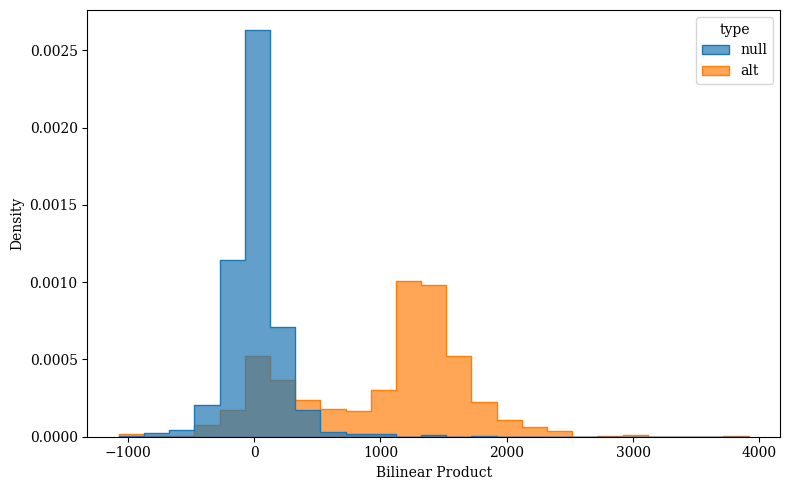

In [115]:


# Compute null distribution
ans = []
for i in range(1000):
        a = np.random.randint(sae1.W_dec.shape[0])
        b = np.random.randint(sae2.W_dec.shape[0])
        val = float(((sae1.W_dec[a, :] @ model.W_U) @ (sae2.W_dec[b, :] @ model.W_U)).detach().cpu().numpy())
        ans.append({'value': val, 'type': 'null'})

# Compute alt distribution
for i in range(1000):
    l = df[['i', 'j', 'topk_i', 'topk_j']].iloc[i].tolist()
    val = float(((sae1.W_dec[l[0], :] @ model.W_U) @ (sae2.W_dec[l[1], :] @ model.W_U)).detach().cpu().numpy())
    ans.append({'value': val, 'type': 'alt'})

# Convert to DataFrame
df_plot = pd.DataFrame(ans)

# Plot with seaborn
plt.figure(figsize=(8, 5))
sns.histplot(data=df_plot, x='value', hue='type', kde=False, stat='density', element='step', common_norm=False, alpha=0.7)
#plt.title("Distribution of Bilinear Products (Null vs Alt)")
plt.xlabel("Bilinear Product")
plt.ylabel("Density")
#plt.legend(title='Distribution')
plt.tight_layout()
plt.show()


In [37]:
import heapq

heap = []  # this will be our max-heap
max_capacity = 100

for a in range(sae1.W_dec.shape[0]):
    for b in range(sae2.W_dec.shape[0]):
        val = float((sae1.W_dec[a, :] @ sae2.W_dec[b, :]).detach().cpu().numpy())
        # Push negative val to make it a max-heap
        
        item = (-val, (a, b))  # negate to simulate max-heap

        if len(heap) < max_capacity:
            heapq.heappush(heap, item)
        else:
            # Push new item and remove smallest (i.e., least negative = smallest dot)
            heapq.heappushpop(heap, item)


KeyboardInterrupt: 

In [46]:
model, sae1, sae2 = feature_corrs.load_model_and_saes('cpu', 'gpt2-small-res-jb', 2, 11)


Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [63]:
get_pretrained_saes_directory().keys()

dict_keys(['deepseek-r1-distill-llama-8b-qresearch', 'gemma-2b-it-res-jb', 'gemma-2b-res-jb', 'gemma-scope-27b-pt-res', 'gemma-scope-27b-pt-res-canonical', 'gemma-scope-2b-pt-att', 'gemma-scope-2b-pt-att-canonical', 'gemma-scope-2b-pt-mlp', 'gemma-scope-2b-pt-mlp-canonical', 'gemma-scope-2b-pt-res', 'gemma-scope-2b-pt-res-canonical', 'gemma-scope-9b-it-res', 'gemma-scope-9b-it-res-canonical', 'gemma-scope-9b-pt-att', 'gemma-scope-9b-pt-att-canonical', 'gemma-scope-9b-pt-mlp', 'gemma-scope-9b-pt-mlp-canonical', 'gemma-scope-9b-pt-res', 'gemma-scope-9b-pt-res-canonical', 'gpt2-small-attn-out-v5-128k', 'gpt2-small-attn-out-v5-32k', 'gpt2-small-hook-z-kk', 'gpt2-small-mlp-out-v5-128k', 'gpt2-small-mlp-out-v5-32k', 'gpt2-small-mlp-tm', 'gpt2-small-res-jb', 'gpt2-small-res-jb-feature-splitting', 'gpt2-small-res_sce-ajt', 'gpt2-small-res_scefr-ajt', 'gpt2-small-res_scl-ajt', 'gpt2-small-res_sle-ajt', 'gpt2-small-res_slefr-ajt', 'gpt2-small-res_sll-ajt', 'gpt2-small-resid-mid-v5-128k', 'gpt2-s

In [79]:
get_pretrained_saes_directory()['llama-3-8b-it-res-jh']

PretrainedSAELookup(release='llama-3-8b-it-res-jh', repo_id='Juliushanhanhan/llama-3-8b-it-res', model='meta-llama/Meta-Llama-3-8B-Instruct', conversion_func=None, saes_map={'blocks.25.hook_resid_post': 'blocks.25.hook_resid_post'}, expected_var_explained={'blocks.25.hook_resid_post': 1.0}, expected_l0={'blocks.25.hook_resid_post': 0.0}, neuronpedia_id={'blocks.25.hook_resid_post': 'llama3-8b-it/25-res-jh'}, config_overrides=None)

In [78]:
W_a = sae1.W_dec.detach().numpy()# np.random.randn(20000, 1000).astype('float32')
W_b = sae2.W_dec.detach().numpy()#np.random.randn(20000, 1000).astype('float32')



In [47]:
import numpy as np
import faiss
import feature_corrs

cpu_index = faiss.IndexFlatIP(1000)
#res = faiss.StandardGpuResources()  # default GPU resources
# Create example data
W_a = sae1.W_dec.detach().numpy()# np.random.randn(20000, 1000).astype('float32')
W_b = sae2.W_dec.detach().numpy()#np.random.randn(20000, 1000).astype('float32')


# Optional: normalize for cosine similarity (unit vectors)
faiss.normalize_L2(W_a)
faiss.normalize_L2(W_b)

# Step 1: Build index on W_b
index = faiss.IndexFlatIP(W_a.shape[1])  # IP = inner product
index.add(W_b)                   # index has 20000 vectors

# Step 2: Search for top-k most similar rows from W_b for each row in W_a
k = 5  # top-k neighbors
D, I = index.search(W_a, k)  # D: similarities, I: indices of matches in W_b

# Print sample of results
print("Similarity scores (D):")
print(D[:5])  # print for first 5 rows

print("\nIndices of top-k matches in W_b (I):")
print(I[:5])  # print for first 5 rows



Similarity scores (D):
[[0.45898816 0.44288117 0.4072416  0.40716505 0.38302565]
 [0.6721623  0.3706767  0.3543048  0.26595566 0.2653752 ]
 [0.29192102 0.24816486 0.22358085 0.22264764 0.21015954]
 [0.6143917  0.5701988  0.5181511  0.4389448  0.35316974]
 [0.37786502 0.26936984 0.2651514  0.2650683  0.26131153]]

Indices of top-k matches in W_b (I):
[[14977  6241 12622  4996 10855]
 [21167 24557 17293 13496 13563]
 [12146 20966 12171  6228  2840]
 [19982 20502  8560  7886 13692]
 [12319 11467 18581 10269  9651]]


In [50]:
D_2_11 = D.copy()

(array([4637., 1279., 2221., 3280., 3135., 2902., 2786., 2839., 1442.,
          55.]),
 array([0.11563949, 0.18769856, 0.25975764, 0.3318167 , 0.40387577,
        0.47593483, 0.5479939 , 0.62005293, 0.69211203, 0.76417106,
        0.83623016]),
 <BarContainer object of 10 artists>)

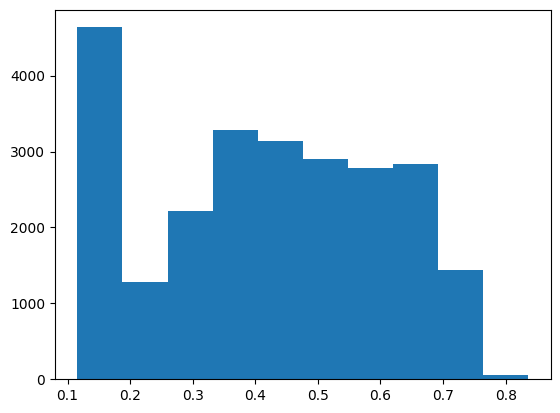

In [51]:
plt.hist(D_2_11[:,0])

In [62]:
max_index = np.unravel_index(np.argmax(D), D.shape)
m1 = max_index[0]
m2 = I[m1, 0]

In [88]:
import numpy as np
import heapq

# Assume you already have:
# D: shape (20000, k) – similarity scores
# I: shape (20000, k) – matching indices in W_b for each W_a row

k = D.shape[1]
num_pairs = 20

# Flatten D and get the top-N indices
flat_indices = np.argpartition(D.flatten(), -num_pairs)[-num_pairs:]
# Sort them by actual similarity
flat_indices = flat_indices[np.argsort(D.flatten()[flat_indices])[::-1]]

# Convert back to 2D indices: row in W_a, rank among its top-k
row_indices, rank_indices = np.unravel_index(flat_indices, D.shape)

# Retrieve (W_a index, W_b index, similarity) for top-20
top_pairs = []
for i in range(num_pairs):
    a_idx = row_indices[i]
    b_idx = I[a_idx, rank_indices[i]]
    sim = D[a_idx, rank_indices[i]]
    top_pairs.append((a_idx, b_idx, sim))

# Print results
for i, (a_idx, b_idx, sim) in enumerate(top_pairs):
    print(f"{i+1:2d}. W_a[{a_idx}] <-> W_b[{b_idx}], similarity = {sim:.4f}")


 1. W_a[9515] <-> W_b[17596], similarity = 0.8362
 2. W_a[21514] <-> W_b[1652], similarity = 0.8323
 3. W_a[5186] <-> W_b[5362], similarity = 0.8118
 4. W_a[397] <-> W_b[19965], similarity = 0.8061
 5. W_a[20704] <-> W_b[2800], similarity = 0.8060
 6. W_a[1839] <-> W_b[7579], similarity = 0.7988
 7. W_a[17932] <-> W_b[14337], similarity = 0.7963
 8. W_a[15789] <-> W_b[11667], similarity = 0.7950
 9. W_a[17135] <-> W_b[12], similarity = 0.7942
10. W_a[23815] <-> W_b[1520], similarity = 0.7889
11. W_a[15398] <-> W_b[23996], similarity = 0.7885
12. W_a[14960] <-> W_b[15669], similarity = 0.7885
13. W_a[14561] <-> W_b[9096], similarity = 0.7868
14. W_a[3845] <-> W_b[11159], similarity = 0.7856
15. W_a[17831] <-> W_b[7142], similarity = 0.7856
16. W_a[19173] <-> W_b[14918], similarity = 0.7842
17. W_a[11771] <-> W_b[17596], similarity = 0.7836
18. W_a[19435] <-> W_b[21566], similarity = 0.7824
19. W_a[18193] <-> W_b[24201], similarity = 0.7810
20. W_a[13570] <-> W_b[20015], similarity = 0.7

In [70]:
get_pretrained_saes_directory().keys()

dict_keys(['deepseek-r1-distill-llama-8b-qresearch', 'gemma-2b-it-res-jb', 'gemma-2b-res-jb', 'gemma-scope-27b-pt-res', 'gemma-scope-27b-pt-res-canonical', 'gemma-scope-2b-pt-att', 'gemma-scope-2b-pt-att-canonical', 'gemma-scope-2b-pt-mlp', 'gemma-scope-2b-pt-mlp-canonical', 'gemma-scope-2b-pt-res', 'gemma-scope-2b-pt-res-canonical', 'gemma-scope-9b-it-res', 'gemma-scope-9b-it-res-canonical', 'gemma-scope-9b-pt-att', 'gemma-scope-9b-pt-att-canonical', 'gemma-scope-9b-pt-mlp', 'gemma-scope-9b-pt-mlp-canonical', 'gemma-scope-9b-pt-res', 'gemma-scope-9b-pt-res-canonical', 'gpt2-small-attn-out-v5-128k', 'gpt2-small-attn-out-v5-32k', 'gpt2-small-hook-z-kk', 'gpt2-small-mlp-out-v5-128k', 'gpt2-small-mlp-out-v5-32k', 'gpt2-small-mlp-tm', 'gpt2-small-res-jb', 'gpt2-small-res-jb-feature-splitting', 'gpt2-small-res_sce-ajt', 'gpt2-small-res_scefr-ajt', 'gpt2-small-res_scl-ajt', 'gpt2-small-res_sle-ajt', 'gpt2-small-res_slefr-ajt', 'gpt2-small-res_sll-ajt', 'gpt2-small-resid-mid-v5-128k', 'gpt2-s

In [82]:
get_pretrained_saes_directory()['deepseek-r1-distill-llama-8b-qresearch']

PretrainedSAELookup(release='deepseek-r1-distill-llama-8b-qresearch', repo_id='qresearch/DeepSeek-R1-Distill-Llama-8B-SAE-l19', model='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', conversion_func='deepseek_r1', saes_map={'blocks.19.hook_resid_post': 'DeepSeek-R1-Distill-Llama-8B-SAE-l19.pt'}, expected_var_explained={'blocks.19.hook_resid_post': 1.0}, expected_l0={'blocks.19.hook_resid_post': 0.0}, neuronpedia_id={'blocks.19.hook_resid_post': 'deepseek-r1-distill-llama-8b/19-qresearch-res-65k'}, config_overrides=None)

In [7]:
from transformer_lens import ActivationCache, HookedTransformer
from sae_lens import SAE

#model = HookedSAETransformer.from_pretrained('deepseek-r1-distill-llama-8b-qresearch', device='cpu')
    
W_distill_dec = SAE.from_pretrained(
    release='deepseek-r1-distill-llama-8b-qresearch',
    sae_id=f"blocks.19.hook_resid_post",
    device=str('cpu'),
)[0].W_dec

In [8]:
    
W_Base_dec = SAE.from_pretrained(
    release='llama-3-8b-it-res-jh',
    sae_id=f"blocks.25.hook_resid_post",
    device=str('cpu'),
)[0].W_dec

sae_weights.safetensors:  31%|###1      | 974M/3.12G [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/262k [00:00<?, ?B/s]

/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:654: UserWarning: norm_scaling_factor not found for llama-3-8b-it-res-jh and blocks.25.hook_resid_post, but normalize_activations is 'expected_average_only_in'. Skipping normalization folding.
  warnings.warn(


In [14]:
import numpy as np
import faiss
import feature_corrs

def get_D(l1=None, l2=None, W_a = None, W_b = None):
    if W_a is None:
        _, s1, s2 = feature_corrs.load_model_and_saes('cpu', 'gpt2-small-res-jb', l1, l2)
        #res = faiss.StandardGpuResources()  # default GPU resources
        # Create example data
        W_a = s1.W_dec.detach().numpy()# np.random.randn(20000, 1000).astype('float32')
        W_b = s2.W_dec.detach().numpy()#np.random.randn(20000, 1000).astype('float32')

    cpu_index = faiss.IndexFlatIP(1000)

    # Optional: normalize for cosine similarity (unit vectors)
    faiss.normalize_L2(W_a)
    faiss.normalize_L2(W_b)

    # Step 1: Build index on W_b
    index = faiss.IndexFlatIP(W_a.shape[1])  # IP = inner product
    index.add(W_b)                   # index has 20000 vectors

    # Step 2: Search for top-k most similar rows from W_b for each row in W_a
    k = 5  # top-k neighbors
    D, I = index.search(W_a, k)  # D: similarities, I: indices of matches in W_b

    # Print sample of results
    print("Similarity scores (D):")
    print(D[:5])  # print for first 5 rows

    print("\nIndices of top-k matches in W_b (I):")
    print(I[:5])  # print for first 5 rows
    
    return D, I
'''
all_pairs = [(1,3), (3, 5), (1, 5), (5, 7), (7, 9), (9, 11), (5,11)]
for (a,b) in all_pairs:
    D, _ = get_D(a,b)
    sns.histplot(D[:, 0], label=f'ρ({a},{b})', stat='density', kde=False, alpha=0.7, element="step")

plt.legend()
plt.xlabel("Latent max-similarity score")
plt.ylabel("Density")
plt.show()
'''

'\nall_pairs = [(1,3), (3, 5), (1, 5), (5, 7), (7, 9), (9, 11), (5,11)]\nfor (a,b) in all_pairs:\n    D, _ = get_D(a,b)\n    sns.histplot(D[:, 0], label=f\'ρ({a},{b})\', stat=\'density\', kde=False, alpha=0.7, element="step")\n\nplt.legend()\nplt.xlabel("Latent max-similarity score")\nplt.ylabel("Density")\nplt.show()\n'

In [25]:
W_distill_dec.detach().cpu().float().numpy()

array([[-0.00187683, -0.00318909,  0.00144958, ..., -0.00180054,
         0.00285339, -0.0020752 ],
       [-0.00177002, -0.00405884,  0.00015736, ..., -0.00216675,
         0.00095367, -0.00201416],
       [-0.00109863, -0.00335693,  0.00344849, ..., -0.00509644,
         0.00350952, -0.00259399],
       ...,
       [ 0.00106049, -0.00354004,  0.00354004, ..., -0.00204468,
         0.0005188 ,  0.00120544],
       [-0.00218201, -0.00114441,  0.00344849, ..., -0.00273132,
        -0.00241089, -0.00048637],
       [-0.00172424, -0.00488281,  0.00296021, ..., -0.00236511,
         0.00162506, -0.00291443]], dtype=float32)

Text(0.5, 0, 'Latent max-similarity score')

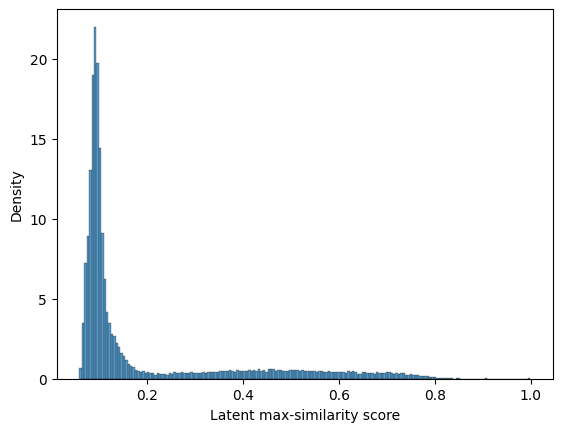

In [53]:
sns.histplot(D[:,0], stat = "density")
plt.xlabel("Latent max-similarity score")

In [37]:
import numpy as np
import heapq

# Assume you already have:
# D: shape (20000, k) – similarity scores
# I: shape (20000, k) – matching indices in W_b for each W_a row

k = D.shape[1]
num_pairs = 100

# Flatten D and get the top-N indices
flat_indices = np.argpartition(D.flatten(), -num_pairs)[-num_pairs:]
# Sort them by actual similarity
flat_indices = flat_indices[np.argsort(D.flatten()[flat_indices])[::-1]]

# Convert back to 2D indices: row in W_a, rank among its top-k
row_indices, rank_indices = np.unravel_index(flat_indices, D.shape)

# Retrieve (W_a index, W_b index, similarity) for top-20
top_pairs = []
for i in range(num_pairs):
    a_idx = row_indices[i]
    b_idx = I[a_idx, rank_indices[i]]
    sim = D[a_idx, rank_indices[i]]
    top_pairs.append((a_idx, b_idx, sim))

# Print results
for i, (a_idx, b_idx, sim) in enumerate(top_pairs):
    print(f"{i+1:2d}. W_a[{a_idx}] <-> W_b[{b_idx}], similarity = {sim:.4f}")


 1. W_a[63640] <-> W_b[47134], similarity = 0.9992
 2. W_a[63640] <-> W_b[62273], similarity = 0.9992
 3. W_a[63640] <-> W_b[28003], similarity = 0.9992
 4. W_a[63640] <-> W_b[57173], similarity = 0.9992
 5. W_a[63640] <-> W_b[54788], similarity = 0.9992
 6. W_a[61132] <-> W_b[47134], similarity = 0.9992
 7. W_a[61132] <-> W_b[62273], similarity = 0.9992
 8. W_a[61132] <-> W_b[28003], similarity = 0.9992
 9. W_a[61132] <-> W_b[57173], similarity = 0.9992
10. W_a[61132] <-> W_b[54788], similarity = 0.9992
11. W_a[9477] <-> W_b[47134], similarity = 0.9992
12. W_a[9477] <-> W_b[62273], similarity = 0.9992
13. W_a[23939] <-> W_b[47134], similarity = 0.9992
14. W_a[9477] <-> W_b[28003], similarity = 0.9992
15. W_a[9477] <-> W_b[57173], similarity = 0.9992
16. W_a[9477] <-> W_b[54788], similarity = 0.9992
17. W_a[2398] <-> W_b[47134], similarity = 0.9992
18. W_a[23939] <-> W_b[62273], similarity = 0.9992
19. W_a[23939] <-> W_b[28003], similarity = 0.9992
20. W_a[23939] <-> W_b[54788], simila

In [50]:
display_dashboard(sae_release='deepseek-r1-distill-llama-8b-qresearch',layer=19,latent_idx=3022,lt = 'post')

PretrainedSAELookup(release='deepseek-r1-distill-llama-8b-qresearch', repo_id='qresearch/DeepSeek-R1-Distill-Llama-8B-SAE-l19', model='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', conversion_func='deepseek_r1', saes_map={'blocks.19.hook_resid_post': 'DeepSeek-R1-Distill-Llama-8B-SAE-l19.pt'}, expected_var_explained={'blocks.19.hook_resid_post': 1.0}, expected_l0={'blocks.19.hook_resid_post': 0.0}, neuronpedia_id={'blocks.19.hook_resid_post': 'deepseek-r1-distill-llama-8b/19-qresearch-res-65k'}, config_overrides=None)
deepseek-r1-distill-llama-8b/19-qresearch-res-65k
https://neuronpedia.org/deepseek-r1-distill-llama-8b/19-qresearch-res-65k/3022?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [47]:
display_dashboard('llama-3-8b-it-res-jh', 25, 47134, lt = 'post')

PretrainedSAELookup(release='llama-3-8b-it-res-jh', repo_id='Juliushanhanhan/llama-3-8b-it-res', model='meta-llama/Meta-Llama-3-8B-Instruct', conversion_func=None, saes_map={'blocks.25.hook_resid_post': 'blocks.25.hook_resid_post'}, expected_var_explained={'blocks.25.hook_resid_post': 1.0}, expected_l0={'blocks.25.hook_resid_post': 0.0}, neuronpedia_id={'blocks.25.hook_resid_post': 'llama3-8b-it/25-res-jh'}, config_overrides=None)
llama3-8b-it/25-res-jh
https://neuronpedia.org/llama3-8b-it/25-res-jh/47134?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Similarity scores (D):
[[0.7736896  0.48565763 0.48323113 0.43281168 0.42006278]
 [0.8256868  0.6950902  0.66747636 0.64440155 0.6182483 ]
 [0.2827432  0.2614268  0.2529068  0.24641821 0.23455943]
 [0.4309636  0.4065518  0.37239772 0.3497087  0.29860017]
 [0.15579657 0.15476006 0.15378696 0.15022138 0.14417806]]

Indices of top-k matches in W_b (I):
[[10213 13280  1480 18189 22282]
 [10279  6482  7007 15421 12164]
 [11402 11199  4097 23342 10789]
 [10545 17659 17645 12755 14212]
 [24010  5091  5627  4965  7793]]
Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Similarity scores (D):
[[0.48971385 0.432966   0.40303212 0.34718496 0.3404836 ]
 [0.74894893 0.5672922  0.37293914 0.36766273 0.3444181 ]
 [0.2672506  0.2419512  0.2398563  0.22490945 0.21454266]
 [0.3752421  0.3389845  0.3050295  0.26702216 0.25470263]
 [0.15101258 0.13813998 0.13627018 0.13335796 0.13242583]]

Indices of top-k matches in W_b (I):
[[  685 23597 17296  5956 14802]
 [  599 16186  6856 15608   949]
 [23905  9747 19103 15595 14562]
 [ 7311 24298 22551  8249  8517]
 [ 4362 20633  1055 18566  1857]]
Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Similarity scores (D):
[[0.4474287  0.29729146 0.2919581  0.27456492 0.26901478]
 [0.64964753 0.341362   0.33502668 0.30081606 0.28184593]
 [0.22779378 0.21090126 0.19637558 0.18248375 0.18207312]
 [0.34890124 0.24958661 0.22761454 0.22495705 0.21478622]
 [0.13451713 0.13244502 0.12350995 0.12321618 0.12212402]]

Indices of top-k matches in W_b (I):
[[15714 12246  6514 12496 21447]
 [15698   305  9452 17947 14934]
 [ 4575  2536 17031  8055  5484]
 [ 8892  5862 22236 10911 23702]
 [ 7321 10884  1471   818  2134]]
Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Similarity scores (D):
[[0.7796464  0.71393764 0.6221011  0.5651187  0.45416358]
 [0.8214861  0.5154207  0.49369073 0.46516216 0.4360322 ]
 [0.14160442 0.12381652 0.12145767 0.11907993 0.11639697]
 [0.7453681  0.59954906 0.3904447  0.34921667 0.32448867]
 [0.13974708 0.13830435 0.13659309 0.13574007 0.11885463]]

Indices of top-k matches in W_b (I):
[[ 3296 21229  5416  7059 13357]
 [ 3067 23012  2808 20248 23076]
 [20059 22964 19943 11613 17833]
 [17326 13039 11429 17883 14718]
 [18512 23139  9236  9896 14416]]
Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Similarity scores (D):
[[0.8880978  0.45970517 0.4536606  0.45142323 0.4232974 ]
 [0.91022205 0.5590751  0.4963607  0.48189992 0.42125195]
 [0.652171   0.51533216 0.4757101  0.4406643  0.4209361 ]
 [0.8979509  0.38383496 0.32949317 0.3142774  0.30798435]
 [0.6671779  0.3901     0.377096   0.32439318 0.32074594]]

Indices of top-k matches in W_b (I):
[[23273  4497 17635 15816 20390]
 [ 4527 15596 12473 24008 17698]
 [ 2575 10920 19003 10137  9280]
 [12714 11638  2520 20651 10659]
 [ 4701  2613 12914  3867  7367]]
Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Similarity scores (D):
[[0.8000746  0.44835937 0.408594   0.3509224  0.34664035]
 [0.66496414 0.45528287 0.38776678 0.37918624 0.3149668 ]
 [0.43109953 0.37265244 0.36901003 0.32538676 0.3229149 ]
 [0.36839572 0.30403203 0.26811394 0.25307524 0.25295267]
 [0.40845674 0.28572744 0.2534832  0.25104833 0.24318224]]

Indices of top-k matches in W_b (I):
[[13235  4221 22951  5178  1654]
 [14111 19481  3279  4530 20674]
 [11809 23015 21853 14425 10196]
 [ 8360  8155  5012 24375 24393]
 [ 1129 19957   386  3489 15388]]
Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Similarity scores (D):
[[0.27189627 0.2567     0.24909748 0.24073188 0.23996356]
 [0.6820309  0.33732125 0.29592    0.28720918 0.2833057 ]
 [0.30931318 0.29473862 0.28678894 0.28081638 0.27585912]
 [0.16447598 0.1634067  0.16321528 0.16193464 0.1566017 ]
 [0.19201729 0.13381478 0.12324448 0.12101048 0.11975363]]

Indices of top-k matches in W_b (I):
[[ 6134 11847 16360 21788  4424]
 [ 8493  7235 11025 14701 21996]
 [11771 19589 22422 18708  5791]
 [23928  3605 16437 23814 14568]
 [13445 11399 23169 10507 17843]]
Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Similarity scores (D):
[[0.6060959  0.36995453 0.36620468 0.36068255 0.3523748 ]
 [0.7653826  0.42365873 0.32788488 0.31402278 0.31388712]
 [0.7228967  0.45571142 0.45213303 0.40615618 0.40599918]
 [0.57133466 0.5374992  0.28514642 0.2744636  0.26328537]
 [0.351015   0.28771877 0.2514832  0.24926503 0.24296105]]

Indices of top-k matches in W_b (I):
[[ 2150  2326  3058  5950 23616]
 [21043 11702 18308  3850 11322]
 [13677  3799 13249 10677  8251]
 [16783 10948     2  9382 21752]
 [17081 12464  1700 16554 13824]]
Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Similarity scores (D):
[[0.36474407 0.36453307 0.362647   0.35608816 0.32767007]
 [0.3114111  0.29478946 0.27348077 0.25694966 0.25373146]
 [0.75687873 0.45040688 0.43990552 0.36540747 0.34835467]
 [0.70702326 0.37493265 0.35739976 0.28989348 0.26693892]
 [0.40237743 0.34457606 0.33705163 0.3260409  0.29573   ]]

Indices of top-k matches in W_b (I):
[[15812  9144 13323  4620  3255]
 [17466 20877 12342  1904 15633]
 [ 5262 20458 11826 15219  1884]
 [21104 22012  1543   355 14563]
 [17613 12623  1642 18536  7803]]
Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Similarity scores (D):
[[0.27693132 0.23725939 0.21595345 0.20638594 0.19744919]
 [0.3760541  0.37503278 0.37328053 0.34740478 0.3262492 ]
 [0.40563923 0.36562756 0.28088588 0.27662385 0.26871735]
 [0.29390502 0.2751652  0.25639343 0.2443382  0.24015033]
 [0.23766428 0.23537897 0.23436975 0.21159217 0.20458293]]

Indices of top-k matches in W_b (I):
[[21120 21001  8721 13445 14179]
 [23120  8247 12183  8129 22032]
 [ 3234 10421  4566 16828 24565]
 [ 2152  4832 19623  4498 11741]
 [23413  2152  9897 11741 10381]]
Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Similarity scores (D):
[[0.38496315 0.36052704 0.35765892 0.32453978 0.31991395]
 [0.48001516 0.44538677 0.427021   0.39473796 0.3944073 ]
 [0.51988184 0.4087221  0.4040583  0.32010502 0.31111318]
 [0.5347563  0.43853444 0.41772515 0.38102615 0.3796317 ]
 [0.38018233 0.36061767 0.32942605 0.3177934  0.31387138]]

Indices of top-k matches in W_b (I):
[[ 7973 23936 10351 17231 17833]
 [20232  8818  5563 23460  5566]
 [13117  8884  4349 19495  7068]
 [19386 15636 20107 15945 10488]
 [13090 16303 19710 14464    99]]
Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Similarity scores (D):
[[0.46208328 0.40952474 0.3912353  0.38129535 0.3656119 ]
 [0.731887   0.48896676 0.40934348 0.4050321  0.39765638]
 [0.6797894  0.4673937  0.46219248 0.4469546  0.40500942]
 [0.79007435 0.6042524  0.5625001  0.5572264  0.5468497 ]
 [0.48608857 0.4597276  0.4586954  0.45798618 0.41908514]]

Indices of top-k matches in W_b (I):
[[ 8868  2723 24109 10320 22196]
 [24470  6107 16927  9395   199]
 [ 2160 22631 12480 10230   348]
 [ 7848   988 15013  2947  2727]
 [23818  4279  6138 10877 12137]]


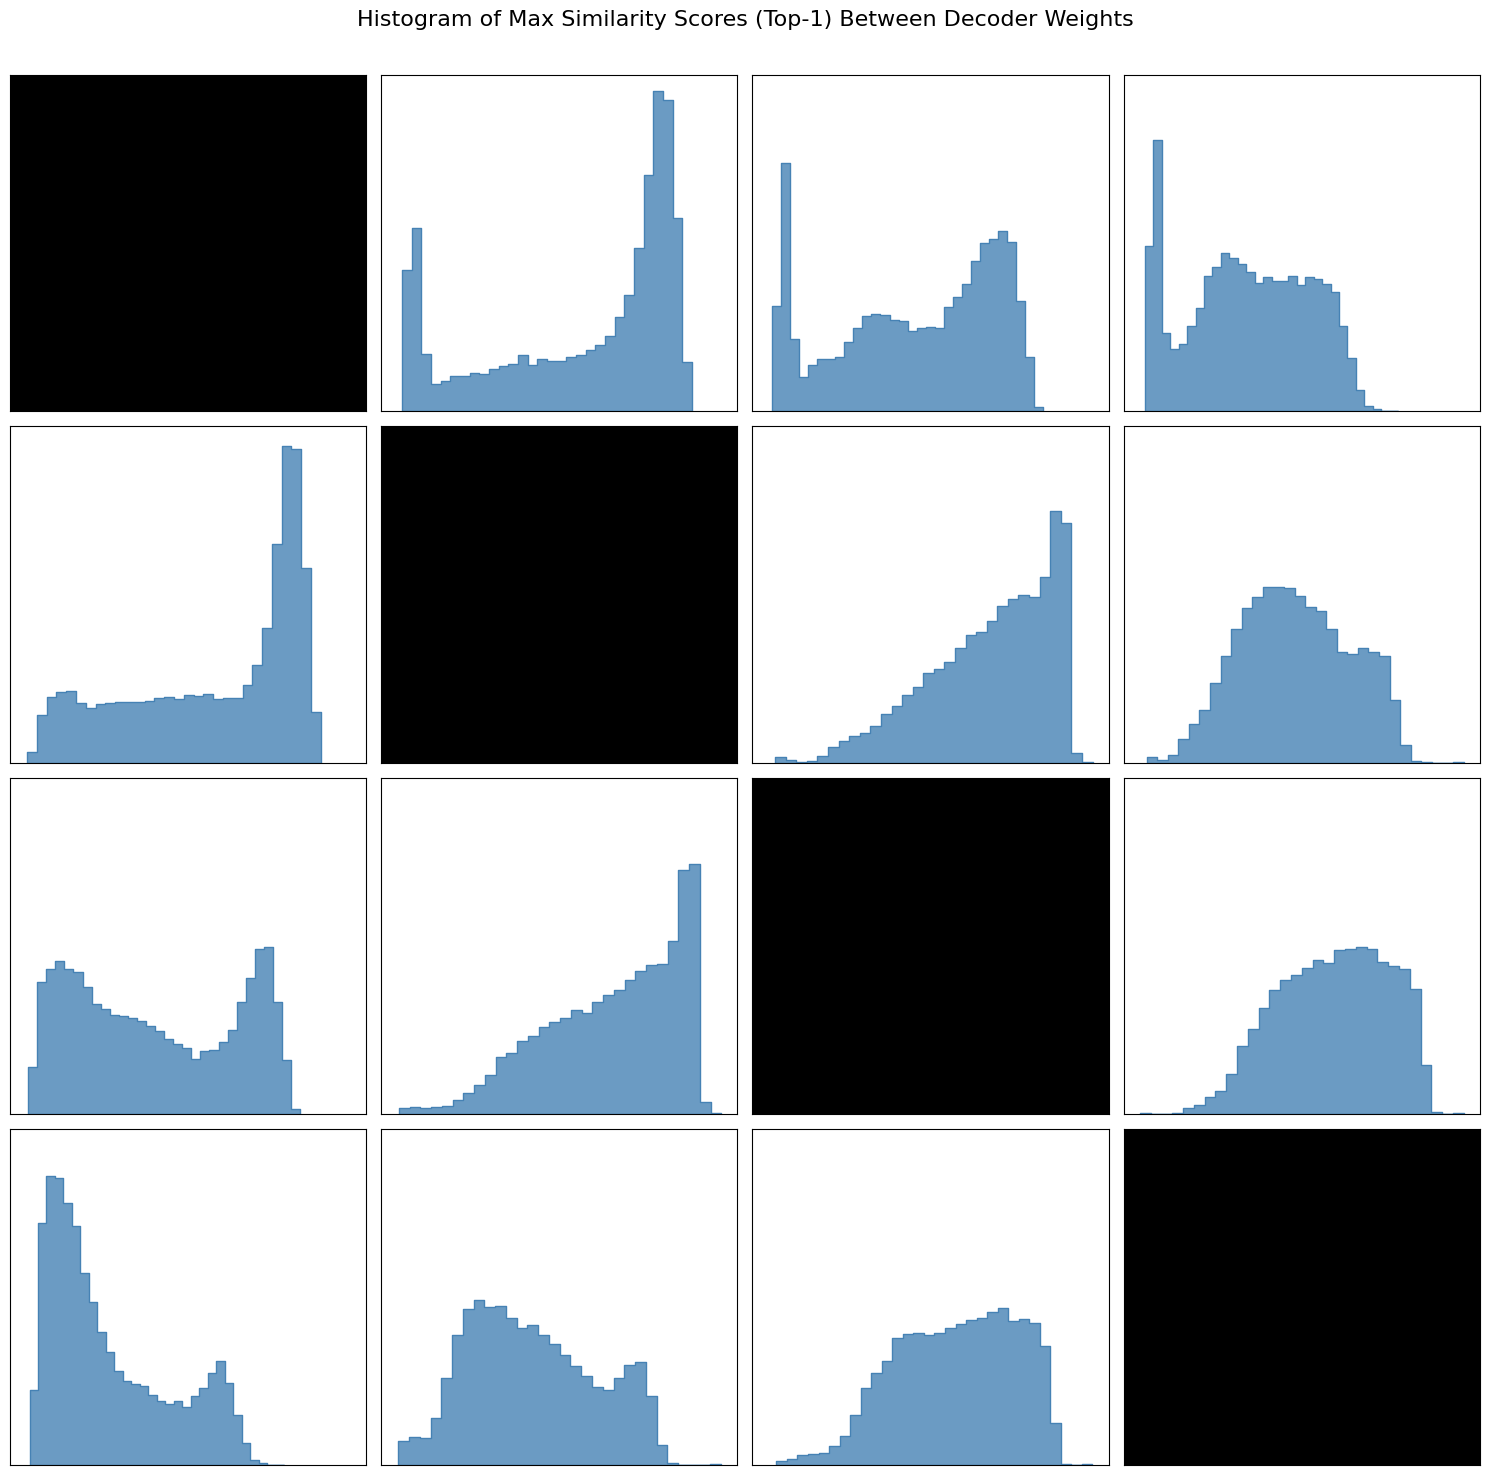

In [55]:
# Choose layers to analyze
layers = [1, 5, 8, 11]
n = len(layers)

# Set up subplot grid
fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(15, 15), sharex=True, sharey=True)

for i, l1 in enumerate(layers):
    for j, l2 in enumerate(layers):
        ax = axes[i, j]

        if i == j:
            # Diagonal: black or blanked out
            ax.set_facecolor('black')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            D, _ = get_D(l1, l2)
            sns.histplot(D[:, 0], bins=30, ax=ax, stat='density', kde=False, element="step", color='steelblue', alpha=0.8)
            if i == n - 1:
                ax.set_xlabel(f'L{l2}')
            else:
                ax.set_xlabel('')
            if j == 0:
                ax.set_ylabel(f'L{l1}')
            else:
                ax.set_ylabel('')

# Tweak layout
plt.suptitle("Histogram of Max Similarity Scores (Top-1) Between Decoder Weights", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


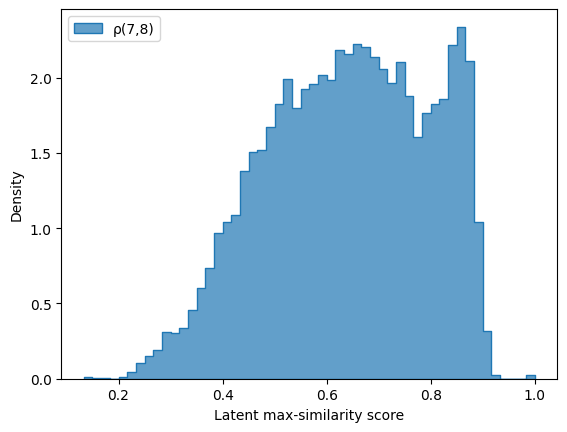

In [66]:
# Plot using seaborn
sns.histplot(D_2_11[:, 0], label='ρ(2,11)', stat='density', kde=False, alpha=0.7, element="step")
sns.histplot(D_7_8[:, 0], label='ρ(7,8)', stat='density', kde=False, alpha=0.7, element="step")

plt.legend()
plt.xlabel("Latent max-similarity score")
plt.ylabel("Density")
plt.show()

In [37]:
import numpy as np
import heapq

# Assume you already have:
# D: shape (20000, k) – similarity scores
# I: shape (20000, k) – matching indices in W_b for each W_a row

k = D.shape[1]
num_pairs = 100

# Flatten D and get the top-N indices
flat_indices = np.argpartition(D.flatten(), -num_pairs)[-num_pairs:]
# Sort them by actual similarity
flat_indices = flat_indices[np.argsort(D.flatten()[flat_indices])[::-1]]

# Convert back to 2D indices: row in W_a, rank among its top-k
row_indices, rank_indices = np.unravel_index(flat_indices, D.shape)

# Retrieve (W_a index, W_b index, similarity) for top-20
top_pairs = []
for i in range(num_pairs):
    a_idx = row_indices[i]
    b_idx = I[a_idx, rank_indices[i]]
    sim = D[a_idx, rank_indices[i]]
    top_pairs.append((a_idx, b_idx, sim))

# Print results
for i, (a_idx, b_idx, sim) in enumerate(top_pairs):
    print(f"{i+1:2d}. W_a[{a_idx}] <-> W_b[{b_idx}], similarity = {sim:.4f}")


 1. W_a[8598] <-> W_b[6955], similarity = 1.0000
 2. W_a[8598] <-> W_b[818], similarity = 1.0000
 3. W_a[11433] <-> W_b[6955], similarity = 1.0000
 4. W_a[8598] <-> W_b[4078], similarity = 1.0000
 5. W_a[8598] <-> W_b[13997], similarity = 1.0000
 6. W_a[8598] <-> W_b[11533], similarity = 1.0000
 7. W_a[22789] <-> W_b[6955], similarity = 1.0000
 8. W_a[12003] <-> W_b[6955], similarity = 1.0000
 9. W_a[11433] <-> W_b[818], similarity = 1.0000
10. W_a[11433] <-> W_b[4078], similarity = 1.0000
11. W_a[11433] <-> W_b[13997], similarity = 1.0000
12. W_a[12003] <-> W_b[4078], similarity = 1.0000
13. W_a[14968] <-> W_b[6955], similarity = 1.0000
14. W_a[21858] <-> W_b[6955], similarity = 1.0000
15. W_a[12003] <-> W_b[818], similarity = 1.0000
16. W_a[22789] <-> W_b[818], similarity = 1.0000
17. W_a[3259] <-> W_b[6955], similarity = 1.0000
18. W_a[14968] <-> W_b[818], similarity = 1.0000
19. W_a[14968] <-> W_b[4078], similarity = 1.0000
20. W_a[12003] <-> W_b[13997], similarity = 1.0000
21. W_a

In [43]:
sae7.W_dec[8598] @ sae7.W_dec[11433]

tensor(1.0000, grad_fn=<DotBackward0>)

In [28]:
sae7.W_dec[8598].detach().numpy().mean()

-7.6522e-05

In [24]:
t.allclose(sae7.W_dec[8598], sae8.W_dec[6955], rtol = 1e-2, atol = 1e-2)

True

(-0.003421951183117926, 5.0731793817251745e-05)

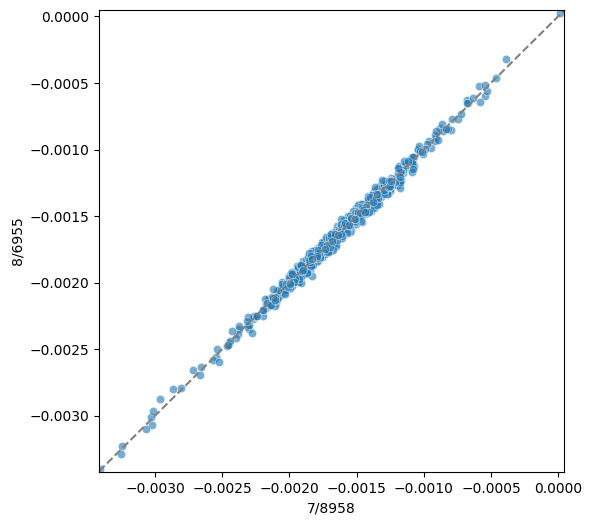

In [44]:
x = sae7.W_dec[8598].detach().cpu().numpy()
y = sae7.W_dec[11433].detach().cpu().numpy()

x_min, x_max = np.quantile(x, [0.01, 0.99])
y_min, y_max = np.quantile(y, [0.01, 0.99])


df = pd.DataFrame({'7/8958': x, '8/6955': y})

# Create the plot
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x='7/8958', y='8/6955', alpha=0.6)

min_val = min(df.min().min(), df.max().min())
max_val = max(df.min().max(), df.max().max())
#plt.plot([min_val, max_val], [min_val, max_val])
plt.plot([x_min, x_max], [x_min, x_max], '--', color='gray')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)


In [42]:
display_dashboard(layer = 7, latent_idx = 11433)

https://neuronpedia.org/gpt2-small/7-res-jb/11433?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [40]:
display_dashboard(layer = 8, latent_idx = 4078)

https://neuronpedia.org/gpt2-small/8-res-jb/4078?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [93]:
W_a[m1,:]@W_b[m2,:]

0.83623016

In [104]:
df[(df['i']==21514)]

,i,j,corr,p_i_given_j,p_j_given_i,topk_i,topk_j


In [85]:
sae1.W_dec[m1,:]@sae2.W_dec[m2,:]

tensor(0.8362, grad_fn=<DotBackward0>)

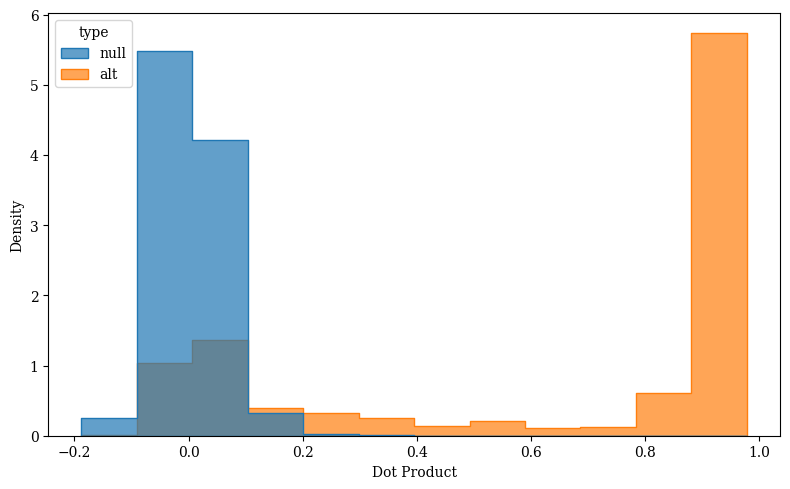

In [116]:
# Compute null distribution
ans = []
for i in range(1000):
    a = np.random.randint(sae1.W_dec.shape[0])
    b = np.random.randint(sae2.W_dec.shape[0])
    val = float(((sae1.W_dec[a, :] @ sae2.W_dec[b, :]).detach().cpu().numpy()))
    ans.append({'value': val, 'type': 'null'})

# Compute alt distribution
for i in range(1000):
    l = df[['i', 'j', 'topk_i', 'topk_j']].iloc[i].tolist()
    val = float(((sae1.W_dec[l[0], :] @ sae2.W_dec[l[1], :]).detach().cpu().numpy()))
    ans.append({'value': val, 'type': 'alt'})

# Convert to DataFrame
df_plot = pd.DataFrame(ans)

# Plot with seaborn
plt.figure(figsize=(8, 5))
sns.histplot(data=df_plot, x='value', hue='type', kde=False, stat='density', element='step', common_norm=False, alpha=0.7)
#plt.title("Distribution of Dot Products (Null vs Alt)")
plt.xlabel("Dot Product")
plt.ylabel("Density")
#plt.legend()#title='Distribution')
plt.tight_layout()
plt.show()


In [30]:
sae1

NameError: name 'sae1' is not defined

In [94]:
float(val)

1224.277587890625

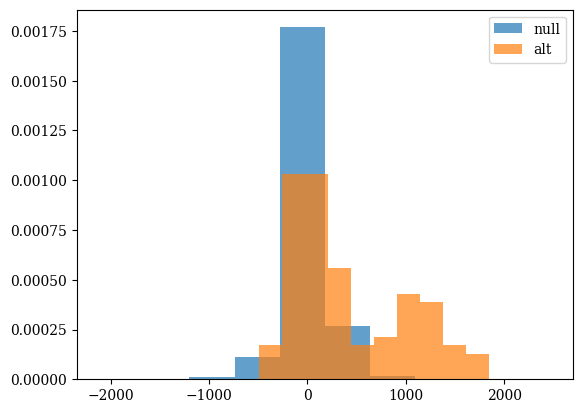

In [314]:
subset[4994]

{'text': ' Ultimate Elixir mixes notes of vanilla orchid and osmanthus top notes with cedarwood and amber middle notes , then adds in vanilla and tonka bean base notes . Kelly Bryant of StyleList wrote that the base notes of Heat Ultimate Elixir " drive the point home that this is a bouquet meant for one sexy siren " . Selling the scent \'s elixir , Macy \'s described the fragrance as an " opulent and intoxicating twist on the original scent . " Keeping with the scent \'s " sexy theme " , the new scarlet jus is contained in the original bottle , updated with a black atomizer , which has been described as " boudoir @-@ ready " by Katherine Kluznik Rentmeester of People magazine . \n'}

In [86]:
display_dashboard(layer=2, latent_idx=m1)

https://neuronpedia.org/gpt2-small/2-res-jb/9515?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [87]:
display_dashboard(layer=11, latent_idx=m2)

https://neuronpedia.org/gpt2-small/11-res-jb/17596?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [273]:
[k for k in get_pretrained_saes_directory().keys() if 'gpt2-small-res' in k]

['gpt2-small-res-jb',
 'gpt2-small-res-jb-feature-splitting',
 'gpt2-small-res_sce-ajt',
 'gpt2-small-res_scefr-ajt',
 'gpt2-small-res_scl-ajt',
 'gpt2-small-res_sle-ajt',
 'gpt2-small-res_slefr-ajt',
 'gpt2-small-res_sll-ajt',
 'gpt2-small-resid-mid-v5-128k',
 'gpt2-small-resid-mid-v5-32k',
 'gpt2-small-resid-post-v5-128k',
 'gpt2-small-resid-post-v5-32k']

## Ablation experiments

In [123]:
from functools import partial

In [199]:
def ablate_sae_latent(
    sae_acts,
    hook,
    latent_idx
):
    """
    Ablate a particular latent at a particular sequence position. If either argument is None, we ablate at all latents
    / sequence positions.
    """
    sae_acts[:,:, latent_idx] = 0
    
def multiply_sae_latent(
    sae_acts,
    hook,
    latent_idx,
    factor = 2
):
    """
    Ablate a particular latent at a particular sequence position. If either argument is None, we ablate at all latents
    / sequence positions.
    """
    sae_acts[:,:, latent_idx] *= factor
    
def run(prompt, model, sae1, sae2, latent1, latent2, precompute = False):
    model.reset_hooks()
    model.reset_saes()
    if precompute:
        _, cache = model.run_with_cache(prompt, names_filter = [sae2.cfg.hook_name],
                                               stop_at_layer = sae2.cfg.hook_layer + 1,start_at_layer = sae1.cfg.hook_layer,
                                               prepend_bos = False)
    else:
        _, cache = model.run_with_cache(prompt, names_filter = [sae2.cfg.hook_name],
                                               stop_at_layer = sae2.cfg.hook_layer + 1,
                                               prepend_bos = False)
    return sae2.encode(cache[sae2.cfg.hook_name])[:,:,latent2].mean(axis = 1)
    
def run_with_reconstruction(prompt, model, sae1, sae2, latent1, latent2, precompute=False):
    model.reset_hooks()
    model.reset_saes()
    with model.saes(saes=[sae1]):
        if precompute:
            _, cache = model.run_with_cache(prompt,
                                            names_filter=[sae2.cfg.hook_name],
                                            stop_at_layer=sae2.cfg.hook_layer + 1,
                                            start_at_layer=sae1.cfg.hook_layer,
                                            prepend_bos=False)
        else:
            _, cache = model.run_with_cache(prompt,
                                            names_filter=[sae2.cfg.hook_name],
                                            stop_at_layer=sae2.cfg.hook_layer + 1,
                                            prepend_bos=False)
        return sae2.encode(cache[sae2.cfg.hook_name])[:, :, latent2].mean(axis=1)

def run_with_steering(prompt, model, sae1, sae2, latent1, latent2, factor = 2, precompute=False):
    model.reset_hooks()
    model.reset_saes()
    with model.saes(saes=[sae1]):
        with model.hooks(fwd_hooks=[(f'{sae1.cfg.hook_name}.hook_sae_acts_post', partial(multiply_sae_latent, latent_idx=latent1, factor = factor))]):
            if precompute:
                _, cache = model.run_with_cache(prompt,
                                                names_filter=[sae2.cfg.hook_name],
                                                stop_at_layer=sae2.cfg.hook_layer + 1,
                                                start_at_layer=sae1.cfg.hook_layer,
                                                prepend_bos=False)
            else:
                _, cache = model.run_with_cache(prompt,
                                                names_filter=[sae2.cfg.hook_name],
                                                stop_at_layer=sae2.cfg.hook_layer + 1,
                                                prepend_bos=False)
            return sae2.encode(cache[sae2.cfg.hook_name])[:, :, latent2].mean(axis=1)

    
def run_with_ablation(prompt, model, sae1, sae2, latent1, latent2, precompute = False):
    model.reset_hooks()
    model.reset_saes()
    with model.saes(saes = [sae1]):
        with model.hooks(fwd_hooks = [(f'{sae1.cfg.hook_name}.hook_sae_acts_post', partial(ablate_sae_latent, latent_idx = latent1))]):
            if precompute:
                _, cache = model.run_with_cache(prompt, names_filter = [sae2.cfg.hook_name],
                                                   stop_at_layer = sae2.cfg.hook_layer + 1,start_at_layer = sae1.cfg.hook_layer,
                                                   prepend_bos = False)
            else:
                _, cache = model.run_with_cache(prompt, names_filter = [sae2.cfg.hook_name],
                                                   stop_at_layer = sae2.cfg.hook_layer + 1,
                                                   prepend_bos = False)
            return sae2.encode(cache[sae2.cfg.hook_name])[:,:,latent2].mean(axis = 1)
                                           

In [203]:
run('how are you', model, sae1, sae2, l[0], l[1])

tensor([[0., 0., 0.]], grad_fn=<SelectBackward0>)

In [141]:
run_with_ablation("how are you", model, sae1, sae2, 0, 1).shape

AssertionError: 

In [161]:
[f'{sae1.cfg.hook_name}.hook_sae_acts_post', partial(ablate_sae_latent, latent_idx = l[0])]

['blocks.7.hook_resid_pre.hook_sae_acts_post',
 functools.partial(<function ablate_sae_latent at 0x7fe0314bea70>, latent_idx=1841)]

In [31]:
model, sae1, sae2 = feature_corrs.load_model_and_saes('cpu',"gpt2-small-res-jb", 2, 11)
df = pd.read_pickle('correlated_features_2_11_wikitext_5000_0.pkl')

2025-06-25 15:03:01.231278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750878181.253563 1575730 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750878181.260283 1575730 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750878181.286449 1575730 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750878181.286485 1575730 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750878181.286490 1575730 computation_placer.cc:177] computation placer alr

Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [209]:
l = df.iloc[np.random.randint(df.shape[0])].tolist()

In [114]:
dataset = load_dataset('wikitext', 'wikitext-103-raw-v1', split = 'train')
subset_size = 50000
batch_size = 8
max_length = 20
subset = dataset.shuffle(seed=0).select(range(subset_size))


In [212]:
l

[12114,
 2912,
 0.9677756428718567,
 0.2142857164144516,
 0.4285714328289032,
 (4029, 1714, 3341),
 (4029, 1773, 1714)]

In [214]:
subset[l[-2][0]]['text']

' In 1964 , after having been introduced to cannabis by Bob Dylan in New York , Epstein was observed by McCartney standing in front of a mirror , pointing at himself and repeatedly saying " Jew ! " , while laughing loudly , which McCartney found hilarious and " very liberating " . Epstein later became heavily involved in the 1960s drug scene . During the four months when the Sgt. Pepper album was being recorded , Epstein spent his time on holiday , or at the Priory Clinic in Putney , where he tried unsuccessfully to curb his drug use . He left the Priory to attend the Sgt. Pepper launch party at his house on 24 Chapel Street , but returned to the Priory immediately after . \n'

In [263]:
sae1.cfg.hook_name

'blocks.2.hook_resid_pre'

In [281]:
ablation_diff = []
reconstruction_diff = []
multiply_diff = []
#ndf = df.sort_values(by = '
for i in range(0,500):
    l = df.iloc[i].tolist()
    _, cache = model.run_with_cache(subset[l[-1][0]]['text'], names_filter = [sae1.cfg.hook_name], stop_at_layer = sae1.cfg.hook_layer + 1, prepend_bos = True)
    first_hook = cache[sae1.cfg.hook_name]
    og = run(first_hook, model, sae1, sae2, l[0], l[1]).sum().detach()
    ablation = run_with_ablation(first_hook, model, sae1, sae2, l[0], l[1]).sum().detach()
    recon = run_with_reconstruction(first_hook, model, sae1, sae2, l[0], l[1]).sum().detach()
    multiply = run_with_steering(first_hook, model, sae1, sae2, l[0], l[1]).sum().detach()
    ablation_diff.append((ablation - og)/og)
    reconstruction_diff.append((recon - og)/og)
    multiply_diff.append((multiply - og)/og)

Text(0, 0.5, 'Ablation difference')

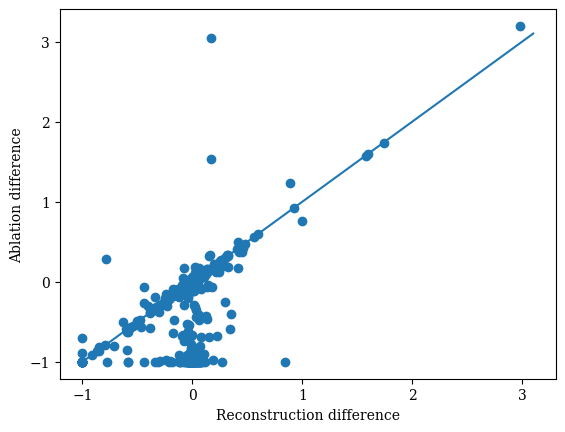

In [283]:
plt.scatter(reconstruction_diff, ablation_diff)
plt.plot([-1, 3.1], [-1, 3.1])
plt.xlabel("Reconstruction difference")
plt.ylabel("Ablation difference")

Text(0, 0.5, 'Ablation difference')

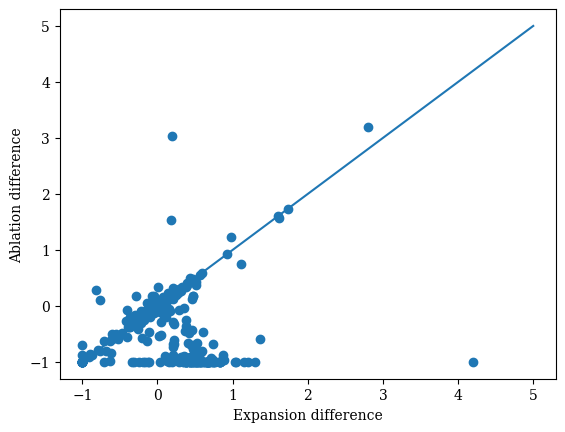

In [290]:
plt.scatter(multiply_diff, ablation_diff)
plt.plot([-1, 5], [-1,5 ])
plt.xlabel("Expansion difference")
plt.ylabel("Ablation difference")

In [294]:
np.argsort(ablation_diff)

array([203, 409, 185,  86, 464, 408, 465,  80, 192, 406,  75,  74, 404,
       399, 180,  69,  68, 211, 394,  63,  62,  61, 393, 391, 221, 226,
       385, 442, 450, 120, 116, 446, 114, 128, 131, 133, 108, 107, 134,
       138, 443, 472, 153, 155, 157,  99, 428, 417, 169, 456, 413, 411,
       461, 174, 331,  32, 282, 229, 284, 350, 288, 289, 349, 342, 333,
       498, 283, 329, 327,  12, 315, 321,   8,   7, 317,   0,   1, 476,
        44, 264, 265,  46, 484, 368,  41, 257, 266, 366, 485, 235, 231,
       230,  36, 324, 279, 320, 486, 132, 191, 269, 496, 109, 303, 296,
       488, 179, 396, 407,   4,  79, 121,  40, 206, 205, 352,   6, 495,
       367, 195, 160,  97, 452, 130, 362,   9, 326, 176, 388, 102, 387,
       127, 255, 351, 111,  10, 126,  35,  78,  11,  96,  84, 143, 204,
       308, 101,  82, 122, 458, 129, 306, 175,  83, 445, 103,  34, 148,
        38,  93, 188,   5, 105, 187, 468, 233, 487,  66, 414, 280, 271,
       395, 142, 455,  39, 489,  21,  72, 295, 216, 141, 166, 36

In [306]:
np.where(np.array(ablation_diff) > 3)

(array([ 31, 163, 299, 382, 431, 483]),)

In [308]:
ablation_diff[163]

tensor(3.1953)

In [309]:
l = df.iloc[163].tolist()

In [310]:
l

[527,
 8045,
 0.9616023302078247,
 1.0,
 0.0833333358168602,
 (4994, 3603, 3591),
 (4994, 1, 0)]

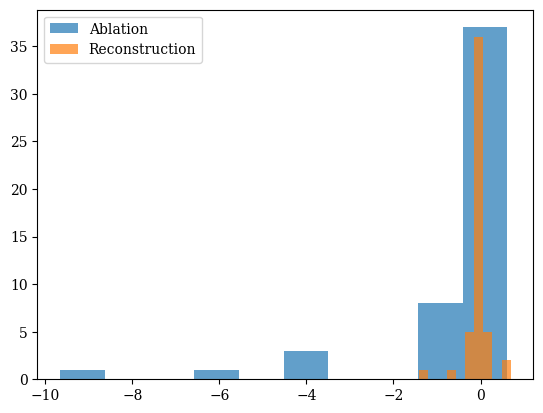

In [269]:
plt.hist(ablation_diff, alpha = 0.7, label = 'Ablation')
plt.hist(reconstruction_diff, alpha = 0.7, label = 'Reconstruction')
plt.legend()

## plot relative feature activations

In [200]:
import feature_corrs

In [201]:
dataloader = feature_corrs.process_dataset(dataset_name="wikitext",
        dataset_config="wikitext-103-raw-v1",subset_size = 20)

In [203]:
feature_corrs.plot_latent_activations(model, sae1, sae2, l[0], l[1])

AttributeError: module 'feature_corrs' has no attribute 'plot_latent_activations'

## sequence position analysis

In [10]:
model, sae1, sae2 = feature_corrs.load_model_and_saes('cpu',"gpt2-small-res-jb", 2, 11)
df = pd.read_pickle('correlated_features_2_11_wikitext_5000_0.pkl')

2025-06-17 13:25:00.466491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750181100.591493 1471540 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750181100.628016 1471540 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750181100.938249 1471540 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750181100.938286 1471540 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750181100.938290 1471540 computation_placer.cc:177] computation placer alr

Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [11]:
dataset = load_dataset('wikitext', 'wikitext-103-raw-v1', split = 'train')
subset_size = 5000
batch_size = 8
max_length = 20
subset = dataset.shuffle(seed=0).select(range(subset_size))


In [34]:
def get_all_caches(prompt, model, sae1, sae2):
    return model.run_with_cache(
                    prompt,
                    names_filter=[sae1.cfg.hook_name, sae2.cfg.hook_name],
                    stop_at_layer=max(sae1.cfg.hook_layer, sae2.cfg.hook_layer) + 1,
                    prepend_bos=False,
                )[1]

def get_activations_diff(cache, model, sae1, sae2, latent_idx1, latent_idx2):
                
    # Get activations for both latents
    act1 = single_latent_encode(layerwise_activations_cache[sae1.cfg.hook_name], latent_idx1, sae1)
    act2 = single_latent_encode(layerwise_activations_cache[sae2.cfg.hook_name], latent_idx2, sae2)
    
    print(act1.shape)
    print(act2.shape)
    
    act1_max_seq = t.argmax(act1, axis = 1)
    act2_max_seq = t.argmax(act2, axis = 1)
    mask = (t.sum(act1, axis = 1) > 0) & (t.sum(act2, axis= 1) > 0)
    max_diff = (act2_max_seq - act1_max_seq)[mask]
    return t.where(mask, act2_max_seq - act1_max_seq, 0.1) # 0.1 indicates that one or the other feature did not appear

In [33]:
def single_latent_encode(vec, i, sae1):
    return t.relu((vec - sae1.b_dec[i]) @ sae1.W_enc[:,i] + sae1.b_enc[i])

In [ ]:
caches = get_all_caches(subset[i:i+100]['text'], model, sae1, sae2)

In [29]:
i = 5
print(subset[i]['text'])
diff = get_activations_diff(subset[i:i+10]['text'], model, sae1, sae2, 0, 0)

 On 26 June 1950 , a Douglas DC @-@ 4 Skymaster aircraft departed from Perth , Western Australia for an eight @-@ hour flight to Adelaide , South Australia . It crashed 18 minutes after take @-@ off , 32 nautical miles ( 59 km ) from Perth Airport . All but one of the 29 occupants were killed in the accident and the sole survivor died six days later . It was the worst civil aviation accident in Australia . 

torch.Size([10, 247])
torch.Size([10, 247])


In [30]:
diff

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])

In [92]:
mask = (diff != 0.1)
avg_diff = (diff * mask).sum(dim=0) / (mask.sum(dim=0).float() + 0.01)

(array([ 24.,  37.,  43.,  62., 139., 273., 225., 117.,  37.,  41.]),
 array([-242.57426453, -193.77818298, -144.98210144,  -96.18602753,
         -47.3899498 ,    1.40612793,   50.20220566,   98.99828339,
         147.7943573 ,  196.59043884,  245.38652039]),
 <BarContainer object of 10 artists>)

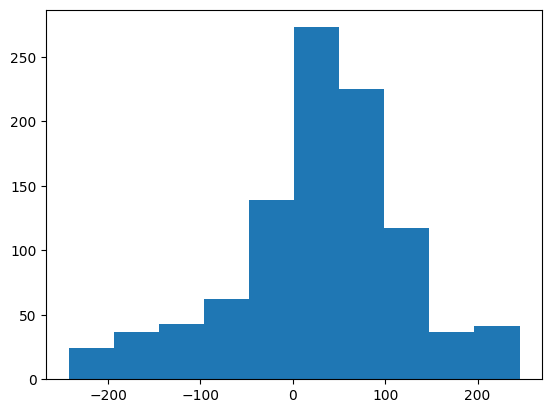

In [102]:
plt.hist(avg_diff[mask.sum(axis = 0) != 0])

In [ ]:
t.nonzero((diff * mask).sum(dim=0))

## new correlations

In [16]:
df = pd.read_pickle("correlated_features_2_11_wikitext_50000_0.pkl")

In [101]:
df[(df['j'] == 17596)]

,i,j,corr,p_i_given_j,p_j_given_i,topk_i,topk_j


In [17]:
df_high_corr = df[(df['corr'] > 0)]

In [27]:
df_high_corr[(df_high_corr['corr'] < 0.99)].sort_values(by = 'corr')

,i,j,corr,p_i_given_j,p_j_given_i,topk_i,topk_j
242,3449,12687,0.900040,0.383721,2.606061,"(44951, 43350, 14407)","(14186, 5993, 31364)"
884,12484,18885,0.900180,0.326733,3.060606,"(45946, 2367, 14761)","(2367, 36883, 45946)"
91,1791,5532,0.900326,26.237288,0.038114,"(15732, 12736, 13398)","(12433, 12736, 47566)"
1615,22271,5421,0.900361,3.400000,0.294118,"(49074, 39931, 19077)","(49074, 19077, 5778)"
1095,15029,7773,0.900426,0.244726,4.086207,"(48406, 47939, 3405)","(48406, 5577, 3405)"
...,...,...,...,...,...,...,...
1038,14995,12338,0.988613,0.200000,5.000000,"(33136, 1498, 26428)","(33136, 14679, 11605)"
371,5962,16774,0.988714,1.084337,0.922222,"(28951, 42325, 14947)","(14947, 38835, 19215)"
510,7655,18096,0.988953,0.390625,2.560000,"(34909, 13273, 42029)","(23675, 13273, 34909)"
1413,19890,17603,0.988979,0.166667,6.000000,"(22445, 22446, 22444)","(22445, 15659, 14533)"


In [167]:
model, sae1, sae2 = feature_corrs.load_model_and_saes('cpu',"gpt2-small-res-jb", 2, 11)

Loaded pretrained model gpt2-small into HookedTransformer


/home/users/sv226/.local/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [172]:
subset[3001]['text']

' An update to Android 4 @.@ 4 @.@ 2 " KitKat " was released in South Korea in November 2013 , and for international models in March 2014 . LG touted a " noticeable speed boost " over Jelly Bean , along with battery life improvements , user interface tweaks , and other improvements brought by KitKat . A further update added a new security feature known as " Knock Code " ( as introduced by the LG G Pro 2 ) , which allows users to unlock their device by tapping quadrants of the screen in a sequence . \n'

In [137]:
c = 1778
i = df.iloc[c]['i']
j = df.iloc[c]['j']
top = subset[set(df.iloc[c]['topk_i']).intersection(set(df.iloc[c]['topk_j'])).pop()]['text']

In [169]:
for c in df.sort_values(by = 'corr', ascending = False).iloc[20:30].index:
    i = df.iloc[c]['i']
    j = df.iloc[c]['j']
    set_int = set(df.iloc[c]['topk_i']).intersection(set(df.iloc[c]['topk_j']))
    if len(set_int) == 0:
        continue
    top = subset[set_int]['text']
    #print(top)
    reg = run(top, model, sae1, sae2, i, j)
    print(f"{i}, {j}")
    print(f"Ablation: {((run_with_ablation(top, model, sae1, sae2, i, j, precompute = False) - reg)/reg).detach().numpy()}")
    print(f"Steering: {((run_with_steering(top, model, sae1, sae2, i, j, precompute = False) - reg)/reg).detach().numpy()}")
    print("-----")

24332, 18013
Ablation: [-0.7657963 -1.       ]
Steering: [ 0.10560826 -0.30281886]
-----
2103, 7145
Ablation: [-0.5886012 -0.5282514 -0.5686277]
Steering: [0.2767895  0.49146944 0.30850828]
-----
23522, 7145
Ablation: [-0.5471645  -0.39700022 -0.5737705 ]
Steering: [0.11575661 0.3322925  0.15558903]
-----
13673, 11487
Ablation: [-0.99421954 -1.         -1.        ]
Steering: [0.41155386 0.1287909  0.27189085]
-----
21243, 20215
Ablation: [-0.98818886]
Steering: [-0.84351695]
-----
14468, 8100
Ablation: [nan nan]
Steering: [nan nan]
-----
4941, 5692
Ablation: [-1.]
Steering: [0.7917872]
-----
23648, 18468
Ablation: [-1.]
Steering: [-0.01907953]
-----


In [198]:
run("Android is Google's Operating System", model, sae1, sae2, 13673, 11487, precompute = False)

tensor([10.8882], grad_fn=<MeanBackward1>)

In [209]:
run_with_steering("NBC Universal", model, sae1, sae2, 4941, 5692)

tensor([0.], grad_fn=<MeanBackward1>)

In [28]:
display_dashboard(layer = 2, latent_idx = 10606)

https://neuronpedia.org/gpt2-small/2-res-jb/10606?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [29]:
display_dashboard(layer = 11, latent_idx = 21276)

https://neuronpedia.org/gpt2-small/11-res-jb/21276?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [51]:
sae1.W_dec[411] @ sae2.W_dec[2300]

tensor(0.6864, grad_fn=<DotBackward0>)

## diff analysis

In [85]:
corr = pd.read_pickle("correlated_features_2_11_wikitext_50000_0.pkl")

In [89]:
merge

,i,j,corr,p_i_given_j,p_j_given_i,topk_i,topk_j
0,222,503,0.945623,3.321678,0.301053,"(18164, 7360, 13077)","(18164, 8453, 27821)"
1,816,607,0.902800,4.333333,0.230769,"(36003, 2222, 26593)","(28537, 33835, 12642)"
2,238,1309,0.917048,0.360000,2.777778,"(23952, 4527, 32670)","(4527, 23952, 49175)"
3,404,1504,0.987931,0.331034,3.020833,"(40950, 16711, 32454)","(49347, 16711, 40932)"
4,489,1598,0.934711,8.906250,0.112281,"(46521, 25113, 9003)","(46521, 25113, 30277)"
...,...,...,...,...,...,...,...
1795,24200,23376,0.951075,0.705263,1.417910,"(17266, 2043, 33440)","(2043, 21036, 41470)"
1796,24204,23406,0.982301,1.455696,0.686957,"(7575, 22046, 28540)","(29926, 17955, 28273)"
1797,24271,23840,0.900851,0.500000,2.000000,"(17144, 44241, 23406)","(17144, 44241, 23406)"
1798,24279,23543,-0.949063,1.727234,0.578960,"(7690, 1476, 35683)","(1, 6, 7)"


In [86]:
diff = pd.read_pickle("diff_correlated_features_2_11_wikitext_50000_0.pkl")

In [87]:
diff.sort_values(by = 'mean', ascending = False).head(20)

,mean,std,count,i,j
98,64.577904,20.773323,16508,1004,7963
84,18.803213,30.182280,249,1599,2527
73,16.653334,26.501062,75,602,22135
60,8.096591,21.870924,176,397,19965
92,7.470900,24.381979,189,1844,5519
90,7.255556,25.946777,90,1009,5099
39,6.153846,21.244352,52,842,13683
91,4.016807,19.879864,119,1791,5532
14,3.288066,16.630816,32253,737,7748
4,2.731707,14.159418,41,489,1598


In [90]:
merge = diff.merge(corr, on = ['i','j'])

In [92]:
merge.sort_values(by = 'mean', ascending = False)

,mean,std,count,i,j,corr,p_i_given_j,p_j_given_i,topk_i,topk_j
98,64.577904,20.773323,16508,1004,7963,-0.908605,1.834610,0.545075,"(12463, 4076, 21187)","(1, 6, 7)"
84,18.803213,30.182280,249,1599,2527,0.916674,49.571430,0.020173,"(48556, 13947, 487)","(1719, 37168, 48556)"
73,16.653334,26.501062,75,602,22135,0.932773,3.591837,0.278409,"(11917, 2423, 32304)","(2423, 32304, 11917)"
60,8.096591,21.870924,176,397,19965,0.928589,0.899628,1.111570,"(31961, 5705, 48796)","(31961, 44927, 5705)"
92,7.470900,24.381979,189,1844,5519,0.940174,3.193333,0.313152,"(14839, 48259, 4879)","(46038, 13311, 4559)"
...,...,...,...,...,...,...,...,...,...,...
55,-2.784615,15.704796,195,124,18966,0.923663,0.250000,4.000000,"(45751, 26942, 40484)","(39697, 20261, 45751)"
16,-2.819444,21.840538,72,432,8061,0.921694,0.483333,2.068965,"(48879, 38086, 30235)","(38086, 30235, 48879)"
66,-3.605430,20.223291,1105,377,20901,0.960688,0.426873,2.342618,"(29179, 31573, 16197)","(29179, 31573, 20499)"
62,-3.611369,7.124838,9922,878,19180,0.919704,1.151684,0.868294,"(25924, 5793, 91)","(37591, 28655, 28576)"


In [66]:
diff['mean'].mean()

4.120108

In [102]:
subset[48556]['text']


' The eyes of slow lorises are forward @-@ facing , which gives stereo vision . Their eyes are large and possess a reflective layer , called the tapetum lucidum , that improves low @-@ light vision . It is possible that this layer blurs the images they see , as the reflected light may interfere with the incoming light . Slow lorises have monochromatic vision , meaning they see in shades of only one color . They lack the opsin gene that would allow them to detect short wavelength light , which includes the colors blue and green . \n'

In [100]:
subset

Dataset({
    features: ['text'],
    num_rows: 5000
})